### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    BayesianRidge,
    ElasticNet,
    HuberRegressor,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    StackingRegressor,
    GradientBoostingRegressor,
)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from tqdm import tqdm

import torch
import torch.nn as nn

### Data Reading

In [2]:
dataset_x = pd.read_json("/Users/emrecavus/Downloads/training-dataset.jsonl", lines=True)
test_set = pd.read_json('/Users/emrecavus/Downloads/test-regression-round3.jsonl', lines = True)

In [3]:
posts_df = pd.json_normalize(dataset_x["posts"])
profile_df = pd.json_normalize(dataset_x["profile"]).drop(
    columns=[
        "id",
        "post_count",
        "full_name",
        "business_category_name",
        "overall_category_name",
        "is_verified_by_mv4b",
        "is_regulated_c18",
        "show_account_transparency_details",
        "ai_agent_type",
        "fb_profile_biolink",
        "restricted_by_viewer",
        "country_block",
        "eimu_id",
        "external_url",
        "fbid",
        "is_supervision_enabled",
        "is_guardian_of_viewer",
        "is_supervised_by_viewer",
        "is_supervised_user",
        "is_embeds_disabled",
        "is_joined_recently",
        "business_email",
        "business_phone_number",
        "profile_picture_base64",
        "business_address_json",
        "profile_pic_url",
        "bio_links",
        "entities",
    ]
)

In [4]:
flattened_posts_df = pd.json_normalize(posts_df.values.flatten())

flattened_posts_df["caption"] = flattened_posts_df["caption"].fillna("")

flattened_posts_df["acc_idx"] = flattened_posts_df.index // 35

flattened_posts_df = flattened_posts_df.merge(
    profile_df["username"], left_on="acc_idx", right_index=True
).drop(columns=["acc_idx"])

flattened_posts_df.dropna(subset=["like_count"], inplace=True)

flattened_posts_df.drop(columns=["media_url"], inplace=True)

Making Use of Category Name

In [5]:
a = profile_df[["category_name", "category_enum"]].dropna().drop_duplicates()

In [6]:
mapping = {}

for i, row in tqdm(a.iterrows(), total=len(a)):
    mapping[row["category_name"]] = row["category_enum"]
    mapping[row["category_enum"]] = row["category_name"]

100%|██████████| 343/343 [00:00<00:00, 69705.23it/s]


In [7]:
profile_df["category_enum"] = profile_df["category_enum"].fillna(
    profile_df["category_name"].map(mapping)
)

profile_df["category_name"] = profile_df["category_name"].fillna(
    profile_df["category_enum"].map(mapping)
)



In [8]:
profile_df.drop("category_enum", axis=1, inplace=True)

profile_df["category_name"] = profile_df["category_name"].fillna("Unknown")
profile_df["biography"] = profile_df["biography"].fillna("")

### Data Preprocessing

1. Registering some category names as others as they are not very frequent

In [9]:
counts = profile_df.category_name.value_counts()
lim = 50

print(
    f"{100 * sum(counts.values < lim) / len(counts):.2f}% is considered as other categories. (Limit: {lim})"
)

others = list(counts.index[counts.values < 50])

profile_df["category_name"] = profile_df["category_name"].apply(
    lambda x: "Other" if x in others else x
)

94.86% is considered as other categories. (Limit: 50)


2. Post Feature Extraction

In [10]:
def extract_post_features(df):
    df["post_hashtag_count"] = df["caption"].apply(
        lambda x: x.count("#") if isinstance(x, str) else 0
    )

    df["post_mention_count"] = df["caption"].apply(
        lambda x: len(re.findall(r"@[\w\d]+", str(x))) if pd.notna(x) else 0
    )

    df["post_url_count"] = df["caption"].apply(
        lambda x: (
            len(
                re.findall(
                    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                    str(x),
                )
            )
            if pd.notna(x)
            else 0
        )
    )

    test_set["post_mention_count"] = test_set["caption"].apply(
        lambda x: len(re.findall(r"@[\w\d]+", str(x))) if pd.notna(x) else 0
    )

    test_set["post_url_count"] = test_set["caption"].apply(
        lambda x: (
            len(
                re.findall(
                    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                    str(x),
                )
            )
            if pd.notna(x)
            else 0
        )
    )

    df["post_emoji_count"] = df["caption"].apply(
        lambda x: (
            len([c for c in str(x) if c in emoji.EMOJI_DATA]) if pd.notna(x) else 0
        )
    )

    test_set["post_emoji_count"] = test_set["caption"].apply(
        lambda x: (
            len([c for c in str(x) if c in emoji.EMOJI_DATA]) if pd.notna(x) else 0
        )
    )

    df["post_length"] = df["caption"].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

    df["post_word_count"] = df["caption"].apply(
        lambda x: len(str(x).split()) if pd.notna(x) else 0
    )

    df["post_exclamation_mark_count"] = df["caption"].apply(
        lambda x: str(x).count("!") if pd.notna(x) else 0
    )

    df["post_question_mark_count"] = df["caption"].apply(
        lambda x: str(x).count("?") if pd.notna(x) else 0
    )


    test_set["post_exclamation_mark_count"] = test_set["caption"].apply(
        lambda x: str(x).count("!") if pd.notna(x) else 0
    )

    test_set["post_question_mark_count"] = test_set["caption"].apply(
        lambda x: str(x).count("?") if pd.notna(x) else 0
    )

    df["post_hour"] = pd.to_datetime(df["timestamp"]).dt.hour
    df["post_day"] = pd.to_datetime(df["timestamp"]).dt.day
    df["post_month"] = pd.to_datetime(df["timestamp"]).dt.month
    df["post_year"] = pd.to_datetime(df["timestamp"]).dt.year
    df["post_weekday"] = pd.to_datetime(df["timestamp"]).dt.dayofweek

    return df

3. Profile Feature Extraction

In [11]:
def extract_profile_features(df):
    df["bio_hashtag_count"] = df["biography"].apply(
        lambda x: x.count("#") if isinstance(x, str) else 0
    )

    df["bio_mention_count"] = df["biography"].apply(
        lambda x: len(re.findall(r"@[\w\d]+", str(x))) if pd.notna(x) else 0
    )

    df["bio_url_count"] = df["biography"].apply(
        lambda x: (
            len(
                re.findall(
                    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                    str(x),
                )
            )
            if pd.notna(x)
            else 0
        )
    )

    df["bio_emoji_count"] = df["biography"].apply(
        lambda x: (
            len([c for c in str(x) if c in emoji.EMOJI_DATA]) if pd.notna(x) else 0
        )
    )

    df["bio_length"] = df["biography"].apply(
        lambda x: len(str(x)) if pd.notna(x) else 0
    )

    df["bio_word_count"] = df["biography"].apply(
        lambda x: len(str(x).split()) if pd.notna(x) else 0
    )

    return df

In [12]:
profile_df = extract_profile_features(profile_df)

cat_features = ["category_name", "business_contact_method"]

for col in cat_features:
    profile_df[col] = profile_df[col].astype("category")

profile_df = pd.get_dummies(profile_df, columns=cat_features)

profile_df.drop(columns=["biography"], inplace=True)

profile_df.head()

,username,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,has_clips,hide_like_and_view_counts,is_professional_account,...,category_name_Product/service,category_name_Public figure,category_name_Restaurant,category_name_Shopping & retail,category_name_Shopping Mall,category_name_Unknown,category_name_Video creator,business_contact_method_CALL,business_contact_method_TEXT,business_contact_method_UNKNOWN
0,deparmedya,1167,192,True,False,False,6,True,False,True,...,False,False,False,False,False,False,False,True,False,False
1,beyazyakaliyiz,1265,665,True,False,False,0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,kafesfirin,11997,17,True,False,False,15,True,False,True,...,False,False,False,False,False,False,False,True,False,False
3,vimerang,2321,454,True,False,False,11,True,True,True,...,False,False,False,False,False,False,True,True,False,False
4,totalenergies_istasyonlari,28025,4,True,False,False,10,True,False,True,...,False,False,False,False,False,False,False,True,False,False


In [13]:
flattened_posts_df = extract_post_features(flattened_posts_df)

cat_features = ["media_type"]

for col in cat_features:
    flattened_posts_df[col] = flattened_posts_df[col].astype("category")

flattened_posts_df = pd.get_dummies(flattened_posts_df, columns=cat_features)

flattened_posts_df.head()

,caption,comments_count,id,like_count,timestamp,username,post_hashtag_count,post_mention_count,post_url_count,post_emoji_count,...,post_exclamation_mark_count,post_question_mark_count,post_hour,post_day,post_month,post_year,post_weekday,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO
0,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,0.0,17990918969458720,6.0,2023-10-29 09:12:30,deparmedya,0,0,0,1,...,0,0,9,29,10,2023,6,False,True,False
1,Oriflame Duologi Lansmanı #isveçtengelengüzell...,1.0,18219250732221045,22.0,2023-08-08 19:11:13,deparmedya,2,0,0,0,...,0,0,19,8,8,2023,1,False,False,True
2,#oriflameilesaçbakımdevrimi ✌️,0.0,18311380465102328,19.0,2023-08-07 21:40:54,deparmedya,1,0,0,1,...,0,0,21,7,8,2023,0,False,False,True
3,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,1.0,18089518138361507,19.0,2023-08-07 21:27:48,deparmedya,1,0,0,1,...,0,0,21,7,8,2023,0,False,False,True
4,07 Agustos’23 #oriflameturkiye #duoloji,0.0,18012743929758497,21.0,2023-08-07 21:12:06,deparmedya,2,0,0,0,...,0,0,21,7,8,2023,0,False,False,True


In [14]:
profile_df.reset_index(drop=True, inplace=True)
flattened_posts_df.reset_index(drop=True, inplace=True)

In [15]:
profile_df.shape, flattened_posts_df.shape

((5415, 44), (183083, 22))

In [16]:
flattened_posts_with_features = pd.merge(
    flattened_posts_df.drop(columns=["caption"]),
    profile_df,
    on="username",
    how="left",
)

flattened_posts_with_features.head()

,comments_count,id,like_count,timestamp,username,post_hashtag_count,post_mention_count,post_url_count,post_emoji_count,post_length,...,category_name_Product/service,category_name_Public figure,category_name_Restaurant,category_name_Shopping & retail,category_name_Shopping Mall,category_name_Unknown,category_name_Video creator,business_contact_method_CALL,business_contact_method_TEXT,business_contact_method_UNKNOWN
0,0.0,17990918969458720,6.0,2023-10-29 09:12:30,deparmedya,0,0,0,1,41,...,False,False,False,False,False,False,False,True,False,False
1,1.0,18219250732221045,22.0,2023-08-08 19:11:13,deparmedya,2,0,0,0,76,...,False,False,False,False,False,False,False,True,False,False
2,0.0,18311380465102328,19.0,2023-08-07 21:40:54,deparmedya,1,0,0,1,30,...,False,False,False,False,False,False,False,True,False,False
3,1.0,18089518138361507,19.0,2023-08-07 21:27:48,deparmedya,1,0,0,1,58,...,False,False,False,False,False,False,False,True,False,False
4,0.0,18012743929758497,21.0,2023-08-07 21:12:06,deparmedya,2,0,0,0,39,...,False,False,False,False,False,False,False,True,False,False


#### Other Calculations: Can be moved up

In [17]:
# Step 1: Calculate average likes and standard deviation of likes for each username
like_stats = flattened_posts_df.groupby("username")["like_count"].agg(
    average_likes="mean",  # Calculate the mean
    std_likes="std",  # Calculate the standard deviation
)

comment_stats = flattened_posts_df.groupby("username")["comments_count"].agg(
    avg_comments_per_account="mean", std_comments_per_account="std"
)

# Step 2: Map average_likes and std_likes back to flattened_posts_with_features
flattened_posts_with_features["average_likes"] = flattened_posts_with_features[
    "username"
].map(like_stats["average_likes"])
flattened_posts_with_features["std_likes"] = (
    flattened_posts_with_features["username"].map(like_stats["std_likes"]).fillna(0)
)
flattened_posts_with_features["avg_comments_per_account"] = (
    flattened_posts_with_features["username"].map(
        comment_stats["avg_comments_per_account"]
    )
)
flattened_posts_with_features["std_comments_per_account"] = (
    flattened_posts_with_features["username"].map(
        comment_stats["std_comments_per_account"]
    )
).fillna(0)


flattened_posts_with_features["custom_metric"] = flattened_posts_with_features.apply(
    lambda row: (
        (
            row["average_likes"]
            if row["comments_count"] == 0
            else (row["comments_count"] / row["avg_comments_per_account"])
            * row["average_likes"]
        )
        if row["avg_comments_per_account"] != 0
        else row["average_likes"]
    ),
    axis=1,
)



### Data Splitting

In [18]:
# Step 2: When creating X (features), include these new columns


X = flattened_posts_with_features.drop(
    columns=["like_count", "timestamp", "id"]
)

test_set = test_set.merge(
    X[['username', 'follower_count', 'following_count', 'is_business_account',
       'is_private', 'is_verified', 'highlight_reel_count', 'has_clips',
       'hide_like_and_view_counts', 'is_professional_account',
       'should_show_category', 'should_show_public_contacts',
       'bio_hashtag_count', 'bio_mention_count', 'bio_url_count',
       'bio_emoji_count', 'bio_length', 'bio_word_count',
       'category_name_Actor', 'category_name_Advertising Agency',
       'category_name_Art', 'category_name_Artist', 'category_name_City Hall',
       'category_name_Clothing (Brand)', 'category_name_Community',
       'category_name_Digital creator', 'category_name_Entrepreneur',
       'category_name_Government organization', 'category_name_Health/beauty',
       'category_name_Hotel', 'category_name_Local business',
       'category_name_Other', 'category_name_Personal blog',
       'category_name_Politician', 'category_name_Product/service',
       'category_name_Public figure', 'category_name_Restaurant',
       'category_name_Shopping & retail', 'category_name_Shopping Mall',
       'category_name_Unknown', 'category_name_Video creator',
       'business_contact_method_CALL', 'business_contact_method_TEXT',
       'business_contact_method_UNKNOWN', 'average_likes', 'std_likes', 'custom_metric', 'avg_comments_per_account', 'std_comments_per_account']],
    on='username',
    how='left'  # Ensures all rows in `test_set` are retained
)

X = X.drop(columns = ["username"])

# Step 4: Set target variable 'like_count' and drop it from X
y = flattened_posts_with_features[
    "like_count"
]  # Extract 'like_count' as target variable

# Step 5: Inspect X and y
print("Features (X):")
print(X.columns)
print("\nTarget (y):")
print(y.head())

Features (X):
Index(['comments_count', 'post_hashtag_count', 'post_mention_count',
       'post_url_count', 'post_emoji_count', 'post_length', 'post_word_count',
       'post_exclamation_mark_count', 'post_question_mark_count', 'post_hour',
       'post_day', 'post_month', 'post_year', 'post_weekday',
       'media_type_CAROUSEL_ALBUM', 'media_type_IMAGE', 'media_type_VIDEO',
       'follower_count', 'following_count', 'is_business_account',
       'is_private', 'is_verified', 'highlight_reel_count', 'has_clips',
       'hide_like_and_view_counts', 'is_professional_account',
       'should_show_category', 'should_show_public_contacts',
       'bio_hashtag_count', 'bio_mention_count', 'bio_url_count',
       'bio_emoji_count', 'bio_length', 'bio_word_count',
       'category_name_Actor', 'category_name_Advertising Agency',
       'category_name_Art', 'category_name_Artist', 'category_name_City Hall',
       'category_name_Clothing (Brand)', 'category_name_Community',
       'category_na

In [19]:
# Applying feature extraction steps for the test set
test_set['post_hashtag_count'] = test_set["caption"].apply(
    lambda x: x.count("#") if isinstance(x, str) else 0
)
test_set["post_length"] = test_set["caption"].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
test_set["post_word_count"] = test_set["caption"].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)
test_set["post_hour"] = pd.to_datetime(test_set["timestamp"]).dt.hour
test_set["post_month"] = pd.to_datetime(test_set["timestamp"]).dt.month
test_set["post_year"] = pd.to_datetime(test_set["timestamp"]).dt.year
test_set["post_weekday"] = pd.to_datetime(test_set["timestamp"]).dt.dayofweek

# Perform one-hot encoding for media_type
media_type_one_hot = pd.get_dummies(test_set['media_type'], prefix='media_type')

# Concatenate the one-hot encoded columns back to the test set
test_set = pd.concat([test_set, media_type_one_hot], axis=1)
test_set = test_set.drop(columns=['media_type'], errors='ignore')

In [20]:
test_set.columns

Index(['caption', 'comments_count', 'id', 'media_url', 'timestamp', 'username',
       'post_mention_count', 'post_url_count', 'post_emoji_count',
       'post_exclamation_mark_count', 'post_question_mark_count',
       'follower_count', 'following_count', 'is_business_account',
       'is_private', 'is_verified', 'highlight_reel_count', 'has_clips',
       'hide_like_and_view_counts', 'is_professional_account',
       'should_show_category', 'should_show_public_contacts',
       'bio_hashtag_count', 'bio_mention_count', 'bio_url_count',
       'bio_emoji_count', 'bio_length', 'bio_word_count',
       'category_name_Actor', 'category_name_Advertising Agency',
       'category_name_Art', 'category_name_Artist', 'category_name_City Hall',
       'category_name_Clothing (Brand)', 'category_name_Community',
       'category_name_Digital creator', 'category_name_Entrepreneur',
       'category_name_Government organization', 'category_name_Health/beauty',
       'category_name_Hotel', 'categ

In [21]:
# Features in X_train but not in test_set
missing_in_test_set = set(X.columns) - set(test_set.columns)
print(f"Features in X_train but not in test_set: {missing_in_test_set}")

# Features in test_set but not in X_train
extra_in_test_set = set(test_set.columns) - set(X.columns)
print(f"Features in test_set but not in X_train: {extra_in_test_set}")

Features in X_train but not in test_set: {'post_day'}
Features in test_set but not in X_train: {'username', 'media_url', 'timestamp', 'caption', 'id'}


In [22]:
test_set['post_day'] = pd.to_datetime(test_set["timestamp"]).dt.day
id_number = test_set['id']
x_test = test_set.drop(columns = ['media_url', 'caption', 'timestamp', 'username', 'id'])

#### Outlier Detection and Removal - Experiment

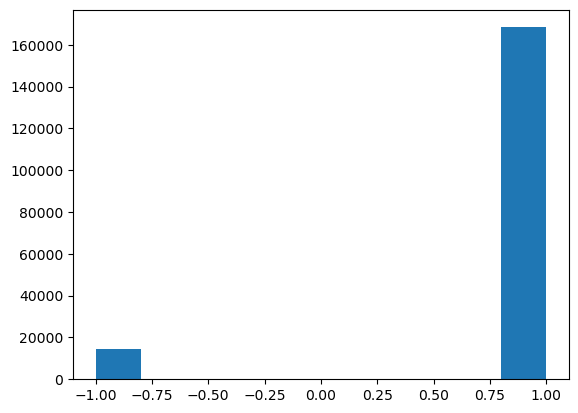

In [24]:
lof = LocalOutlierFactor()
outliers = lof.fit_predict(X)

plt.hist(outliers)
plt.show()

In [25]:
X = X[outliers == 1].reset_index(drop=True)
y = y[outliers == 1].reset_index(drop=True)

In [26]:
X.shape, y.shape

((168362, 65), (168362,))

In [27]:
x_test.shape

(101454, 65)

#### Data Scaling - Only for Numerical Features

In [28]:
cat_cols = [
    "media_type_CAROUSEL_ALBUM",
    "media_type_IMAGE",
    "media_type_VIDEO",
    "category_name_Actor",
    "category_name_Advertising Agency",
    "category_name_Art",
    "category_name_Artist",
    "category_name_City Hall",
    "category_name_Clothing (Brand)",
    "category_name_Community",
    "category_name_Digital creator",
    "category_name_Entrepreneur",
    "category_name_Government organization",
    "category_name_Health/beauty",
    "category_name_Hotel",
    "category_name_Local business",
    "category_name_Other",
    "category_name_Personal blog",
    "category_name_Politician",
    "category_name_Product/service",
    "category_name_Public figure",
    "category_name_Restaurant",
    "category_name_Shopping & retail",
    "category_name_Shopping Mall",
    "category_name_Unknown",
    "category_name_Video creator",
    "business_contact_method_CALL",
    "business_contact_method_TEXT",
    "business_contact_method_UNKNOWN",
]

num_cols = X.columns.difference(cat_cols)
num_cols_test = x_test.columns.difference(cat_cols)

print(f"Number of numerical columns: {len(num_cols)}")

scaler = StandardScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])

x_test[num_cols_test] = scaler.fit_transform(x_test[num_cols_test])

X

Number of numerical columns: 36


,comments_count,post_hashtag_count,post_mention_count,post_url_count,post_emoji_count,post_length,post_word_count,post_exclamation_mark_count,post_question_mark_count,post_hour,...,category_name_Unknown,category_name_Video creator,business_contact_method_CALL,business_contact_method_TEXT,business_contact_method_UNKNOWN,average_likes,std_likes,avg_comments_per_account,std_comments_per_account,custom_metric
0,-0.113558,-0.729336,-0.112142,-0.112486,-0.190672,-0.779791,-0.761307,-0.456470,-0.245803,-0.727972,...,False,False,True,False,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210
1,-0.111871,-0.442441,-0.112142,-0.112486,-0.514492,-0.671459,-0.737590,-0.456470,-0.245803,1.613163,...,False,False,True,False,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.127709
2,-0.113558,-0.585889,-0.112142,-0.112486,-0.190672,-0.813838,-0.808741,-0.456470,-0.245803,2.081390,...,False,False,True,False,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210
3,-0.111871,-0.585889,-0.112142,-0.112486,-0.190672,-0.727173,-0.785024,-0.456470,-0.245803,2.081390,...,False,False,True,False,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.127709
4,-0.113558,-0.442441,-0.112142,-0.112486,-0.514492,-0.785981,-0.761307,-0.456470,-0.245803,2.081390,...,False,False,True,False,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168357,-0.111871,3.143741,-0.112142,-0.112486,0.780789,0.684235,0.590567,0.790948,-0.245803,0.208482,...,False,False,True,False,False,-0.140025,-0.138177,-0.137409,-0.062009,-0.128393
168358,-0.111871,3.143741,-0.112142,-0.112486,0.780789,0.517095,0.400831,0.790948,-0.245803,-1.196199,...,False,False,True,False,False,-0.140025,-0.138177,-0.137409,-0.062009,-0.128393
168359,-0.113558,-0.729336,-0.112142,-0.112486,0.133148,-0.832409,-0.785024,-0.456470,-0.245803,-0.025632,...,False,False,True,False,False,-0.140025,-0.138177,-0.137409,-0.062009,-0.127601
168360,-0.110183,3.143741,-0.112142,-0.112486,0.780789,0.876137,0.685436,2.038365,-0.245803,0.910822,...,False,False,True,False,False,-0.140025,-0.138177,-0.137409,-0.062009,-0.128316


In [29]:
x_test

,comments_count,post_mention_count,post_url_count,post_emoji_count,post_exclamation_mark_count,post_question_mark_count,follower_count,following_count,is_business_account,is_private,...,post_length,post_word_count,post_hour,post_month,post_year,post_weekday,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO,post_day
0,-0.101786,-0.103972,-0.125062,-0.500487,-0.329854,-0.243438,-0.130211,0.486508,0.64298,-0.018578,...,-0.386665,-0.413409,-0.041894,0.964287,0.451203,-0.412483,True,False,False,-1.654953
1,-0.101786,-0.103972,-0.125062,-0.500487,-0.329854,-0.243438,-0.130211,0.486508,0.64298,-0.018578,...,-0.386665,-0.413409,-0.041894,0.964287,0.451203,-0.412483,True,False,False,-1.654953
2,-0.101786,-0.103972,-0.125062,-0.500487,-0.329854,-0.243438,-0.130211,0.486508,0.64298,-0.018578,...,-0.386665,-0.413409,-0.041894,0.964287,0.451203,-0.412483,True,False,False,-1.654953
3,-0.101786,-0.103972,-0.125062,-0.500487,-0.329854,-0.243438,-0.130211,0.486508,0.64298,-0.018578,...,-0.386665,-0.413409,-0.041894,0.964287,0.451203,-0.412483,True,False,False,-1.654953
4,-0.101786,-0.103972,-0.125062,-0.500487,-0.329854,-0.243438,-0.130211,0.486508,0.64298,-0.018578,...,-0.386665,-0.413409,-0.041894,0.964287,0.451203,-0.412483,True,False,False,-1.654953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101449,-0.103099,-0.103972,-0.125062,-0.199706,-0.329854,-0.243438,-0.071943,0.600700,0.64298,-0.018578,...,-0.091681,-0.321240,2.059563,0.964287,0.451203,0.111594,False,True,False,-0.771176
101450,-0.103099,-0.103972,-0.125062,-0.199706,-0.329854,-0.243438,-0.071943,0.600700,0.64298,-0.018578,...,-0.091681,-0.321240,2.059563,0.964287,0.451203,0.111594,False,True,False,-0.771176
101451,-0.103099,-0.103972,-0.125062,-0.199706,-0.329854,-0.243438,-0.071943,0.600700,0.64298,-0.018578,...,-0.091681,-0.321240,2.059563,0.964287,0.451203,0.111594,False,True,False,-0.771176
101452,-0.103099,-0.103972,-0.125062,-0.199706,-0.329854,-0.243438,-0.071943,0.600700,0.64298,-0.018578,...,-0.091681,-0.321240,2.059563,0.964287,0.451203,0.111594,False,True,False,-0.771176


### Feature Selection - Experiment

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_select = SelectKBest(score_func=f_regression, k=30)

feature_select.fit_transform(X, y)

selected_cols = X.columns[feature_select.get_support()]
selected_cols_test = x_test.columns[feature_select.get_support()]

print(list(selected_cols))

X = X[selected_cols]

x_test = x_test[selected_cols_test]

X.head()

['comments_count', 'post_hashtag_count', 'post_length', 'post_word_count', 'post_hour', 'post_month', 'media_type_CAROUSEL_ALBUM', 'media_type_IMAGE', 'follower_count', 'is_business_account', 'is_verified', 'should_show_category', 'should_show_public_contacts', 'bio_hashtag_count', 'bio_mention_count', 'bio_length', 'bio_word_count', 'category_name_Actor', 'category_name_Artist', 'category_name_Other', 'category_name_Product/service', 'category_name_Public figure', 'category_name_Video creator', 'business_contact_method_CALL', 'business_contact_method_UNKNOWN', 'average_likes', 'std_likes', 'avg_comments_per_account', 'std_comments_per_account', 'custom_metric']


,comments_count,post_hashtag_count,post_length,post_word_count,post_hour,post_month,media_type_CAROUSEL_ALBUM,media_type_IMAGE,follower_count,is_business_account,...,category_name_Product/service,category_name_Public figure,category_name_Video creator,business_contact_method_CALL,business_contact_method_UNKNOWN,average_likes,std_likes,avg_comments_per_account,std_comments_per_account,custom_metric
0,-0.113558,-0.729336,-0.779791,-0.761307,-0.727972,0.612740,False,True,-0.129535,0.636457,...,False,False,False,True,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210
1,-0.111871,-0.442441,-0.671459,-0.737590,1.613163,-0.096949,False,False,-0.129535,0.636457,...,False,False,False,True,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.127709
2,-0.113558,-0.585889,-0.813838,-0.808741,2.081390,-0.096949,False,False,-0.129535,0.636457,...,False,False,False,True,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210
3,-0.111871,-0.585889,-0.727173,-0.785024,2.081390,-0.096949,False,False,-0.129535,0.636457,...,False,False,False,True,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.127709
4,-0.113558,-0.442441,-0.785981,-0.761307,2.081390,-0.096949,False,False,-0.129535,0.636457,...,False,False,False,True,False,-0.140606,-0.138815,-0.156351,-0.102687,-0.128210


In [31]:
x_test.head()

,comments_count,post_mention_count,post_question_mark_count,follower_count,is_private,highlight_reel_count,is_professional_account,should_show_category,bio_hashtag_count,bio_url_count,...,std_likes,custom_metric,post_word_count,post_hour,post_year,post_weekday,media_type_CAROUSEL_ALBUM,media_type_IMAGE,media_type_VIDEO,post_day
0,-0.101786,-0.103972,-0.243438,-0.130211,-0.018578,-0.089326,0.026278,0.463174,-0.332297,-0.081546,...,-0.123692,-0.116347,-0.413409,-0.041894,0.451203,-0.412483,True,False,False,-1.654953
1,-0.101786,-0.103972,-0.243438,-0.130211,-0.018578,-0.089326,0.026278,0.463174,-0.332297,-0.081546,...,-0.123692,-0.115482,-0.413409,-0.041894,0.451203,-0.412483,True,False,False,-1.654953
2,-0.101786,-0.103972,-0.243438,-0.130211,-0.018578,-0.089326,0.026278,0.463174,-0.332297,-0.081546,...,-0.123692,-0.100624,-0.413409,-0.041894,0.451203,-0.412483,True,False,False,-1.654953
3,-0.101786,-0.103972,-0.243438,-0.130211,-0.018578,-0.089326,0.026278,0.463174,-0.332297,-0.081546,...,-0.123692,-0.113751,-0.413409,-0.041894,0.451203,-0.412483,True,False,False,-1.654953
4,-0.101786,-0.103972,-0.243438,-0.130211,-0.018578,-0.089326,0.026278,0.463174,-0.332297,-0.081546,...,-0.123692,-0.118077,-0.413409,-0.041894,0.451203,-0.412483,True,False,False,-1.654953


#### Train-Validation Split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((151525, 30), (16837, 30), (151525,), (16837,))

#### Model Selection

In [36]:
def train_model_and_report(model, X_train, y_train, X_val, y_val):
    print(f"Training {model.__class__.__name__}...")
    model.fit(X_train, y_train)

    y_train_model = model.predict(X_train)
    y_pred_model = model.predict(X_val)

    print(f"{model.__class__.__name__}:")
    print("\tTrain R2 score:", r2_score(y_train, y_train_model))
    print("\tTest R2 score:", r2_score(y_val, y_pred_model))
    print("\tTrain MAE:", mean_absolute_error(y_train, y_train_model))
    print("\tTest MAE:", mean_absolute_error(y_val, y_pred_model), "\n")


def cross_val_model(model, X, y, cv=5):
    print(f"Cross-validating {model.__class__.__name__}...")
    scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    print(f"{model.__class__.__name__} CV R2: {scores.mean()}\n\n")

In [37]:
models = [
    #LinearRegression(positive=False, fit_intercept=True),
    #Lasso(random_state=42),
    #Ridge(random_state=42, solver='lsqr', fit_intercept=True, alpha=100.0),
    #BayesianRidge(),
    #ElasticNet(random_state=42),
    #RandomForestRegressor(random_state=42),
    #GradientBoostingRegressor(),
    #XGBRegressor(random_state=42),
    LGBMRegressor(
        random_state=42, 
        verbose=-1, 
        num_leaves= 200,
        learning_rate= 0.05,
        n_estimators=150,
        min_child_samples=20,
        subsample=0.85,
        colsample_bytree=0.8,
        reg_alpha= 0.15,
        reg_lambda=0.15,
    )
    #KNeighborsRegressor(),
    #DecisionTreeRegressor(random_state=42),
    #SVR(),
]

In [38]:
for model in models:
    train_model_and_report(model, X_train, y_train, X_val, y_val)
    cross_val_model(model, X, y)

Training LGBMRegressor...
LGBMRegressor:
	Train R2 score: 0.955397968973102
	Test R2 score: 0.9221522434696414
	Train MAE: 1190.6985764806109
	Test MAE: 1853.750106047334 

Cross-validating LGBMRegressor...
LGBMRegressor CV R2: 0.6229707204582886




#### Custom Class For Training the Ensemble Model

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
#warnings.filterwarnings('ignore')

class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, weights=None):
        # Initialize the five models with optimized parameters
        self.lgbm = LGBMRegressor(
            random_state=42,
            verbose=-1,
            num_leaves=150,  # Reduced from 200 to prevent overfitting
            learning_rate=0.03,  # Reduced for better generalization
            n_estimators=200,  # Increased for better performance
            min_child_samples=30,  # Increased to reduce overfitting
            subsample=0.8,
            colsample_bytree=0.7,  # Reduced due to 25 features
            reg_alpha=0.2,
            reg_lambda=0.2
        )
        
        self.xgb = XGBRegressor(
            random_state=42,
            n_estimators=200,
            learning_rate=0.03,
            max_depth=6,  # Reduced due to high RMSE
            min_child_weight=4,
            subsample=0.8,
            colsample_bytree=0.7,
            reg_alpha=0.2,
            reg_lambda=0.2,
            verbosity=0
        )
        
        self.catboost = CatBoostRegressor(
            random_state=42,
            iterations=200,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,
            subsample=0.8,
            verbose=False
        )
        
        self.rf = RandomForestRegressor(
            n_estimators=150,
            max_depth=12,  # Added max_depth to control complexity
            min_samples_split=5,
            min_samples_leaf=3,
            random_state=42,
            n_jobs=-1
        )
        
        self.mlp = MLPRegressor(
            hidden_layer_sizes=(50, 25),  # Reduced due to 25 features
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size=32,
            learning_rate='adaptive',
            max_iter=1500,
            early_stopping=True,
            random_state=42
        )
        
        # Default weights based on expected performance
        self.default_weights = {
            'LightGBM': 0.25,
            'XGBoost': 0.25,
            'CatBoost': 0.20,
            'RandomForest': 0.15,
            'MLP': 0.0
        }
        
        # Use provided weights or defaults
        self.weights = weights if weights is not None else list(self.default_weights.values())
        
        # Store models in ordered dictionary to maintain consistency
        self.models = {
            'LightGBM': self.lgbm,
            'XGBoost': self.xgb,
            'CatBoost': self.catboost,
            'RandomForest': self.rf,
            'MLP': self.mlp
        }
        
    def fit(self, X, y):
        """Fit all models in the ensemble."""
        print("Training Enhanced Ensemble Models...")
        
        # Train each model
        for name, model in self.models.items():
            print(f"Training {name}...")
            if name == 'CatBoost':
                # CatBoost requires special handling for the training pool
                model.fit(X, y, silent=True)
            else:
                model.fit(X, y)
        
        return self
    
    def predict(self, X):
        """Make weighted predictions using all models."""
        predictions = []
        
        # Get predictions from each model
        for model in self.models.values():
            pred = model.predict(X)
            predictions.append(pred)
        
        # Calculate weighted average
        weighted_pred = np.average(predictions, weights=self.weights, axis=0)
        return weighted_pred
    
    def evaluate(self, X, y):
        """Evaluate both individual models and ensemble."""
        predictions = []
        results = {}
        
        # Evaluate each model
        for name, model in self.models.items():
            preds = model.predict(X)
            predictions.append(preds)
            
            # Calculate metrics
            r2 = r2_score(y, preds)
            mae = mean_absolute_error(y, preds)
            rmse = np.sqrt(mean_squared_error(y, preds))
            
            results[name] = {
                'R2': r2,
                'MAE': mae,
                'RMSE': rmse
            }
        
        # Evaluate ensemble
        ensemble_preds = np.average(predictions, weights=self.weights, axis=0)
        results['Ensemble'] = {
            'R2': r2_score(y, ensemble_preds),
            'MAE': mean_absolute_error(y, ensemble_preds),
            'RMSE': np.sqrt(mean_squared_error(y, ensemble_preds))
        }
        
        return results
    
    def get_feature_importance(self, feature_names=None):
        """Get feature importance from tree-based models."""
        if not feature_names:
            feature_names = [f'feature_{i}' for i in range(self.models['LightGBM'].n_features_in_)]
        
        importance_dict = {}
        
        # Get feature importance for tree-based models
        for name, model in self.models.items():
            if name != 'MLP':  # Skip MLP as it doesn't have direct feature importance
                try:
                    importance = model.feature_importances_
                    model_importance = dict(zip(feature_names, importance))
                    importance_dict[name] = dict(sorted(
                        model_importance.items(),
                        key=lambda x: x[1],
                        reverse=True
                    ))
                except AttributeError:
                    continue
        
        return importance_dict

def train_and_evaluate_ensemble(X_train, y_train, X_val, y_val, weights=None):
    """
    Train and evaluate the enhanced ensemble model.
    
    Parameters:
    -----------
    X_train, y_train: Training data
    X_val, y_val: Validation data
    weights: Optional list of weights for the five models
    
    Returns:
    --------
    ensemble: Trained ensemble model
    results: Dictionary with performance metrics
    """
    # Initialize and train ensemble
    ensemble = CustomEnsembleRegressor(weights=weights)
    ensemble.fit(X_train, y_train)
    
    # Get performance metrics
    train_results = ensemble.evaluate(X_train, y_train)
    val_results = ensemble.evaluate(X_val, y_val)
    
    print("\nTraining Results:")
    for model_name, metrics in train_results.items():
        print(f"\n{model_name}:")
        print(f"R2 Score: {metrics['R2']:.4f}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"RMSE: {metrics['RMSE']:.4f}")
    
    print("\nValidation Results:")
    for model_name, metrics in val_results.items():
        print(f"\n{model_name}:")
        print(f"R2 Score: {metrics['R2']:.4f}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"RMSE: {metrics['RMSE']:.4f}")
    
    return ensemble, {'train': train_results, 'val': val_results}

In [46]:
# Convert all object columns to numerical using one-hot encoding
x_test = pd.get_dummies(x_test, drop_first=True)
x_test = x_test.fillna(0)
x_test = x_test.reindex(columns=X_train.columns, fill_value=0)

In [41]:
# Create and train ensemble
ensemble = CustomEnsembleRegressor() 
results = train_and_evaluate_ensemble(X_train, y_train, X_val, y_val)

Training Enhanced Ensemble Models...
Training LightGBM...
Training XGBoost...
Training CatBoost...
Training RandomForest...
Training MLP...

Training Results:

LightGBM:
R2 Score: 0.9226
MAE: 1479.6897
RMSE: 12005.1541

XGBoost:
R2 Score: 0.9416
MAE: 1666.7245
RMSE: 10433.6926

CatBoost:
R2 Score: 0.8912
MAE: 2156.5799
RMSE: 14235.7419

RandomForest:
R2 Score: 0.9478
MAE: 1362.9597
RMSE: 9857.0668

MLP:
R2 Score: 0.8451
MAE: 2492.7737
RMSE: 16985.3276

Ensemble:
R2 Score: 0.9327
MAE: 1611.5585
RMSE: 11193.3237

Validation Results:

LightGBM:
R2 Score: 0.9242
MAE: 1855.7908
RMSE: 13457.7249

XGBoost:
R2 Score: 0.8978
MAE: 1972.5487
RMSE: 15632.7170

CatBoost:
R2 Score: 0.9164
MAE: 2131.3647
RMSE: 14137.2318

RandomForest:
R2 Score: 0.9229
MAE: 1859.1843
RMSE: 13576.3623

MLP:
R2 Score: 0.9234
MAE: 2340.7585
RMSE: 13532.0276

Ensemble:
R2 Score: 0.9215
MAE: 1891.1986
RMSE: 13697.3716


In [49]:
import json

# Step 1: Train the ensemble
ensemble = CustomEnsembleRegressor(weights=[0.25, 0.25, 0.20, 0.15, 0.15])  # Adjust weights as needed
ensemble.fit(X_train, y_train)

# Step 2: Predict on the test set
predictions = ensemble.predict(x_test)

# Step 3: Round predictions to the nearest integer
rounded_predictions = [int(round(pred)) for pred in predictions]

# Step 4: Create a dictionary with id_number and rounded predictions
prediction_dict = dict(zip(id_number, rounded_predictions))

# Step 5: Save the predictions to a JSON file, each on a new line
output_file = "prediction-regression-round3.json"
with open(output_file, "w") as file:
    for key, value in prediction_dict.items():
        file.write(f'"{key}": {value},\n')

print(f"Predictions saved to {output_file}")


Training Enhanced Ensemble Models...
Training LightGBM...
Training XGBoost...
Training CatBoost...
Training RandomForest...
Training MLP...
Predictions saved to prediction-regression-round3.json


#### Hyperparameter Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np

# LightGBM Tuning

lgbm_params = {
    'num_leaves': [10, 20, 30, 50, 75, 100, 125, 150, 175, 200],
    'learning_rate': [0.001, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_child_samples': [20, 50, 75, 100, 125, 150],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.05, 0.1, 0.15, 0.25, 0.3, 0.4, 0.5],
    'reg_lambda': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
}


# KNeighbors Tuning
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Linear Regression with regularization parameters
linear_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Ridge Regression
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept': [True, False]
}

# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt']
}

# XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

def tune_model(X_train, y_train, model, param_grid, cv=5, n_iter=50, scoring='r2'):
    """
    Perform hyperparameter tuning using RandomizedSearchCV
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Target values
    model : estimator object
        The model to tune
    param_grid : dict
        Parameter grid to search
    cv : int
        Number of cross-validation folds
    n_iter : int
        Number of parameter settings sampled
    scoring : string
        Scoring metric to use
        
    Returns:
    --------
    dict
        Best parameters and scores
    """
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=3,
        random_state=42,
        verbose=2
    )
    
    random_search.fit(X_train, y_train)
    
    return {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'best_estimator': random_search.best_estimator_
    }

# Example usage for each model:
def tune_all_models(X_train, y_train):
    models = {
        'lgbm': (LGBMRegressor(random_state=42), lgbm_params),
        'knn': (KNeighborsRegressor(), knn_params),
        'linear': (LinearRegression(), linear_params),
        'ridge': (Ridge(random_state=42), ridge_params),
        'gb': (GradientBoostingRegressor(random_state=42), gb_params),
        'xgb': (XGBRegressor(random_state=42), xgb_params)
    }
    
    results = {}
    for name, (model, params) in models.items():
        print(f"\nTuning {name}...")
        results[name] = tune_model(X_train, y_train, model, params)
        print(f"\nBest parameters for {name}:")
        print(results[name]['best_params'])
        print(f"Best CV score: {results[name]['best_score']:.4f}")
    
    return results